# Fine-tuning Embeddings for Design Data

Let's see if we can improve the quality of our returned results using a fine-tuned embedding model trained on our designs!

We'll use SentenceTransformers to fine-tune our embedding model, as it provides a straightforward approach for adapting models to specific domains.

In [1]:
# Install required packages if needed
# !pip install sentence-transformers datasets torch matplotlib

In [2]:
import json
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader

## 1. Load Design Data

First, we'll load the design data from our existing dataset.

In [3]:
def load_design_data():
    """Load design data from the metadata files"""
    designs_dir = Path.cwd().parent / "src" / "data" / "designs"
    print(designs_dir)
    designs = []
    
    # Load all metadata files
    for design_dir in designs_dir.glob("**/metadata.json"):
        try:
            with open(design_dir, "r") as f:
                metadata = json.load(f)
            
            # Create a text representation of the design
            text = f"""Design {metadata.get('id', 'unknown')}:
            Description: {metadata.get('description', 'No description available')}
            Categories: {', '.join(metadata.get('categories', []))}
            Visual Characteristics: {', '.join(metadata.get('visual_characteristics', []))}
            """
            
            designs.append({
                'id': metadata.get('id', 'unknown'),
                'text': text.strip(),
                'categories': metadata.get('categories', []),
                'visual_characteristics': metadata.get('visual_characteristics', [])
            })
        except Exception as e:
            print(f"Error processing design {design_dir}: {e}")
            continue
    
    print(f"Loaded {len(designs)} designs")
    return designs

designs = load_design_data()
designs_df = pd.DataFrame(designs)
designs_df.head()

/Users/owner/Desktop/Projects/ai-maker-space/code/ImagineUI/src/data/designs
Loaded 141 designs


,id,text,categories,visual_characteristics
0,135,Design 135:\n Description: This des...,"[Traditional, Elegant, Text-Heavy, Classic]","[Muted Color Palette, Vertical Layout, Serif T..."
1,132,Design 132:\n Description: This des...,"[minimalist, nature-inspired, modern, zen-them...","[white background, green accents, illustrative..."
2,104,Design 104:\n Description: The CSS ...,"[minimalism, elegance, typography, web design ...","[subtle color palette, classic serif fonts, cl..."
3,103,Design 103:\n Description: This des...,"[vintage, classical, dramatic, ornate, elegant]","[dark color palette, gold accents, traditional..."
4,168,Design 168:\n Description: This des...,"[Humorous, Educational, Whimsical, Nature-them...","[Vibrant color palette, Whimsical illustration..."


## 2. Create Training Pairs

For fine-tuning, we need to create positive pairs (similar designs) and negative pairs (dissimilar designs). We'll use categories and visual characteristics to determine similarity.

In [8]:
from sentence_transformers import InputExample
def create_training_pairs(designs_df, num_pairs=5000):
    """Create training pairs for fine-tuning"""
    training_pairs = []
    design_ids = designs_df['id'].tolist()
    
    # Calculate similarity between designs based on categories and characteristics
    def calculate_similarity(design1, design2):
        # Get categories and characteristics for both designs
        cats1 = set(design1['categories'])
        cats2 = set(design2['categories'])
        chars1 = set(design1['visual_characteristics'])
        chars2 = set(design2['visual_characteristics'])
        
        # Calculate Jaccard similarity for categories and characteristics
        cat_sim = len(cats1.intersection(cats2)) / max(1, len(cats1.union(cats2)))
        char_sim = len(chars1.intersection(chars2)) / max(1, len(chars1.union(chars2)))
        
        # Weighted similarity
        return 0.5 * cat_sim + 0.5 * char_sim
    
    # Create similarity matrix
    import random
    train_examples = []
    eval_examples = []
    
    # Create positive pairs (similar designs)
    for i in range(len(designs_df)):
        design1 = designs_df.iloc[i].to_dict()
        similarities = []
        
        for j in range(len(designs_df)):
            if i != j:
                design2 = designs_df.iloc[j].to_dict()
                sim = calculate_similarity(design1, design2)
                similarities.append((j, sim))
        
        # Sort by similarity
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        # Add top similar designs as positive pairs
        for j, sim in similarities[:3]:  # Top 3 most similar
            if sim > 0.2:  # Only if they're somewhat similar
                design2 = designs_df.iloc[j].to_dict()
                # Create InputExample with texts and similarity score
                example = InputExample(texts=[design1['text'], design2['text']], label=float(sim))
                
                # 80% for training, 20% for evaluation
                if random.random() < 0.8:
                    train_examples.append(example)
                else:
                    eval_examples.append(example)
    
    print(f"Created {len(train_examples)} training examples and {len(eval_examples)} evaluation examples")
    return train_examples, eval_examples

print("Creating training pairs...")
train_examples, eval_examples = create_training_pairs(designs_df)            

Creating training pairs...
Created 95 training examples and 27 evaluation examples


## 3. Fine-tune the Model

The model I've selected here is the distilbert-base-nli-stsb-mean-tokens model, chosen as a comparison because its BERT training is effective at semantic similarity. Performance isn't too important here, since we have one design per query and we want to return the best match.

In [10]:
def fine_tune_model_simple(train_examples, eval_examples, base_model="sentence-transformers/distilbert-base-nli-stsb-mean-tokens"):
    """Fine-tune a SentenceTransformer model"""
    import os
    import torch
    from datetime import datetime
    from sentence_transformers import SentenceTransformer, losses
    from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
    from torch.utils.data import DataLoader
    
    # Load the base model
    print(f"Loading base model: {base_model}")
    model = SentenceTransformer(base_model)
    
    # Create training dataloader
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
    
    # Use CosineSimilarityLoss for fine-tuning
    train_loss = losses.CosineSimilarityLoss(model)
    
    # Create evaluator
    evaluator = EmbeddingSimilarityEvaluator.from_input_examples(eval_examples)
    
    # Create timestamped model save path
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_save_path = os.path.join(os.getcwd(), "fine_tuned_design_embeddings_" + timestamp)
    
    # Set up warm-up steps
    warmup_steps = int(len(train_dataloader) * 0.1)

    print(f"\nTraining configuration:")
    print(f"- Training examples: {len(train_examples)}")
    print(f"- Evaluation examples: {len(eval_examples)}")
    print(f"- Batch size: 16")
    print(f"- Warmup steps: {warmup_steps}")
    print(f"- Using GPU: {torch.cuda.is_available()}")
    print(f"- Model will be saved to: {model_save_path}")
    
    # Train the model
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        evaluator=evaluator,
        epochs=1,  # Start with just 1 epoch to test
        warmup_steps=warmup_steps,
        output_path=model_save_path,
        show_progress_bar=True
    )
    
    print(f"\nTraining complete!")
    print(f"Model saved to {model_save_path}")
    
    return model, model_save_path

print("Starting model fine-tuning...")
fine_tuned_model, model_path = fine_tune_model_simple(train_examples, eval_examples)


Starting model fine-tuning...
Loading base model: sentence-transformers/distilbert-base-nli-stsb-mean-tokens

Training configuration:
- Training examples: 95
- Evaluation examples: 27
- Batch size: 16
- Warmup steps: 0
- Using GPU: False
- Model will be saved to: /Users/owner/Desktop/Projects/ai-maker-space/code/ImagineUI/src/fine_tuned_design_embeddings_20250225_161918


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
6,No log,No log,-0.139605,-0.068639



Training complete!
Model saved to /Users/owner/Desktop/Projects/ai-maker-space/code/ImagineUI/src/fine_tuned_design_embeddings_20250225_161918


## 4. Evaluate Fine-tuned Model vs Base Model

We'll need nest_asyncio to run the async evaluation inside a Jupyter notebook.

In [14]:
import nest_asyncio
nest_asyncio.apply()

In [16]:
# Now define a synchronous wrapper for our comparison function
def compare_models_sync(base_model_name, fine_tuned_model_path, test_queries):
    """Synchronous wrapper for compare_models"""
    import asyncio
    from langchain_openai import ChatOpenAI
    import json
    
    # Load models
    print(f"Loading base model: {base_model_name}")
    base_model = SentenceTransformer(base_model_name)
    
    print(f"Loading fine-tuned model from: {fine_tuned_model_path}")
    fine_tuned_model = SentenceTransformer(fine_tuned_model_path)
    
    # Initialize evaluator
    llm = ChatOpenAI(model="gpt-4", temperature=0)
    
    # Create a retrieval function using each model
    def retrieve_with_model(model, query, k=1):
        # Get embeddings for designs
        design_texts = designs_df['text'].tolist()
        design_embeddings = model.encode(design_texts, convert_to_tensor=True)
        
        # Get query embedding
        query_embedding = model.encode(query, convert_to_tensor=True)
        
        # Calculate cosine similarities
        cos_scores = torch.nn.functional.cosine_similarity(query_embedding.unsqueeze(0), design_embeddings)
        
        # Get top k designs
        top_k_indices = torch.topk(cos_scores, k=k).indices.tolist()
        
        # Return top k designs
        return [designs_df.iloc[i] for i in top_k_indices]
    
    # Evaluate a design match
    async def evaluate_match(query, design):
        prompt = f"""You are evaluating a design recommendation system.
        
        USER REQUIREMENTS:
        {query}
        
        RECOMMENDED DESIGN:
        {design['text']}
        
        Score how well the recommended design matches the user's requirements on a scale of 0-10.
        Provide your score and brief explanation in JSON format exactly like this:
        {{
            "score": 7,
            "reason": "The design aligns with the requirements because..."
        }}
        
        Return only valid JSON, nothing else.
        """
        
        try:
            response = await llm.ainvoke(prompt)
            result = json.loads(response.content)
            return result
        except Exception as e:
            print(f"Error evaluating match: {e}")
            return {"score": 0, "reason": f"Error parsing evaluation: {e}"}
    
    # Test with both models
    results = []
    
    # Define the evaluation function
    async def evaluate_all_queries():
        for i, query in enumerate(test_queries):
            print(f"Evaluating query {i+1}/{len(test_queries)}: {query[:50]}...")
            
            # Get top result from each model
            base_result = retrieve_with_model(base_model, query)[0]
            fine_tuned_result = retrieve_with_model(fine_tuned_model, query)[0]
            
            # Evaluate matches
            base_eval = await evaluate_match(query, base_result)
            fine_tuned_eval = await evaluate_match(query, fine_tuned_result)
            
            # Store results
            results.append({
                "query": query,
                "base_model_id": base_result['id'],
                "fine_tuned_model_id": fine_tuned_result['id'],
                "base_score": base_eval.get("score", 0),
                "base_reason": base_eval.get("reason", "Error"),
                "fine_tuned_score": fine_tuned_eval.get("score", 0),
                "fine_tuned_reason": fine_tuned_eval.get("reason", "Error"),
                "models_differ": base_result['id'] != fine_tuned_result['id']
            })
            
            print(f"  Base model: Design {base_result['id']} - Score: {base_eval.get('score', 0)}")
            print(f"  Fine-tuned: Design {fine_tuned_result['id']} - Score: {fine_tuned_eval.get('score', 0)}")
    
    # Run the async evaluation using the event loop
    loop = asyncio.get_event_loop()
    loop.run_until_complete(evaluate_all_queries())
    
    return pd.DataFrame(results)

In [17]:

test_queries = [
    "I need a minimalist design with lots of whitespace",
    "Looking for a playful, colorful design with rounded elements",
    "Need a professional business design with a dark theme",
    "Want a nature-inspired design with organic shapes",
    "Looking for a tech-focused design with a futuristic feel",
    "I want the craziest design you can find",
    "I'd like an eye-catching design for a small business",
    "I want something clinical and informative"
]

comparison_results = compare_models_sync("sentence-transformers/distilbert-base-nli-stsb-mean-tokens", model_path, test_queries)
comparison_results

Loading base model: sentence-transformers/distilbert-base-nli-stsb-mean-tokens
Loading fine-tuned model from: /Users/owner/Desktop/Projects/ai-maker-space/code/ImagineUI/src/fine_tuned_design_embeddings_20250225_161918
Evaluating query 1/8: I need a minimalist design with lots of whitespace...
  Base model: Design 220 - Score: 8
  Fine-tuned: Design 144 - Score: 9
Evaluating query 2/8: Looking for a playful, colorful design with rounde...
  Base model: Design 129 - Score: 8
  Fine-tuned: Design 129 - Score: 8
Evaluating query 3/8: Need a professional business design with a dark th...
  Base model: Design 204 - Score: 8
  Fine-tuned: Design 204 - Score: 8
Evaluating query 4/8: Want a nature-inspired design with organic shapes...
  Base model: Design 190 - Score: 8
  Fine-tuned: Design 215 - Score: 0
Evaluating query 5/8: Looking for a tech-focused design with a futuristi...
  Base model: Design 012 - Score: 9
  Fine-tuned: Design 012 - Score: 9
Evaluating query 6/8: I want the craziest 

,query,base_model_id,fine_tuned_model_id,base_score,base_reason,fine_tuned_score,fine_tuned_reason,models_differ
0,I need a minimalist design with lots of whites...,220,144,8,The design aligns with the user's requirements...,9,The recommended design matches the user's requ...,True
1,"Looking for a playful, colorful design with ro...",129,129,8,The design aligns with the user's requirements...,8,The design aligns with the user's requirements...,False
2,Need a professional business design with a dar...,204,204,8,The design aligns with the user's requirements...,8,The design aligns with the user's requirements...,False
3,Want a nature-inspired design with organic shapes,190,215,8,The design aligns with the user's requirements...,0,The recommended design does not match the user...,True
4,Looking for a tech-focused design with a futur...,012,012,9,The recommended design aligns very well with t...,9,The recommended design aligns very well with t...,False
5,I want the craziest design you can find,008,008,8,The design aligns with the user's requirements...,8,The recommended design matches the user's requ...,False
6,I'd like an eye-catching design for a small bu...,006,006,8,The recommended design matches the user's requ...,8,The recommended design matches the user's requ...,False
7,I want something clinical and informative,130,004,8,The recommended design matches the user's requ...,8,The design aligns with the user's requirements...,True


Using this, we can verify the returned design of each model and query. A standout element is the "0" scored by the fine-tuned model for query #3. Checking the returned design, it's definitely not the nature-inspired design we were looking for. The model without fine-tuning hasn't missed a query that badly, so it's unclear why the training moved in the wrong direction.

## 5. Visualize Comparison Results

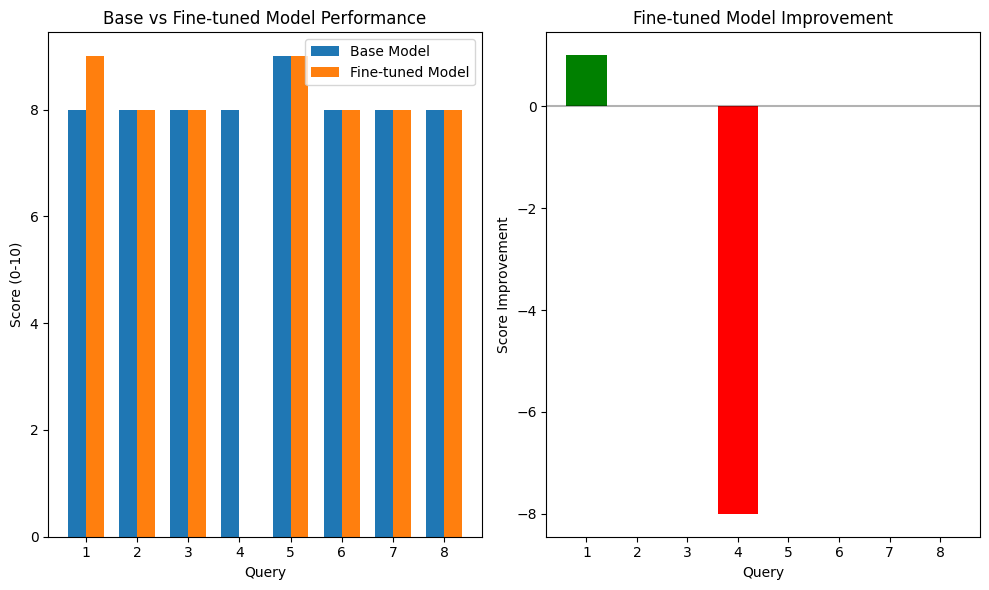

Average Base Model Score: 8.12
Average Fine-tuned Model Score: 7.25
Average Improvement: -0.88 (-10.8%)


In [18]:
# Visualize comparison results
plt.figure(figsize=(10, 6))

# Calculate improvement
comparison_results['improvement'] = comparison_results['fine_tuned_score'] - comparison_results['base_score']

# Bar chart comparing scores
plt.subplot(1, 2, 1)
x = np.arange(len(comparison_results))
width = 0.35

plt.bar(x - width/2, comparison_results['base_score'], width, label='Base Model')
plt.bar(x + width/2, comparison_results['fine_tuned_score'], width, label='Fine-tuned Model')

plt.xlabel('Query')
plt.ylabel('Score (0-10)')
plt.title('Base vs Fine-tuned Model Performance')
plt.xticks(x, range(1, len(comparison_results) + 1))
plt.legend()

# Improvement chart
plt.subplot(1, 2, 2)
colors = ['green' if x > 0 else 'red' for x in comparison_results['improvement']]
plt.bar(range(1, len(comparison_results) + 1), comparison_results['improvement'], color=colors)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('Query')
plt.ylabel('Score Improvement')
plt.title('Fine-tuned Model Improvement')

plt.tight_layout()
plt.show()

# Show overall improvement
avg_base_score = comparison_results['base_score'].mean()
avg_fine_tuned_score = comparison_results['fine_tuned_score'].mean()
avg_improvement = avg_fine_tuned_score - avg_base_score

print(f"Average Base Model Score: {avg_base_score:.2f}")
print(f"Average Fine-tuned Model Score: {avg_fine_tuned_score:.2f}")
print(f"Average Improvement: {avg_improvement:.2f} ({avg_improvement/avg_base_score*100:.1f}%)")

## Conclusion

We were able to train a fine-tuned model on our queries and designs, but the results were disappointing. We don't want to launch an embedding model that hurts our performance so we'll stick with the existing rag agent. But with more queries, more data, and testing more models, there may be a way to find improvements.